In [1]:
input_filepath = "/Users/kristianernst/Work/Learning/MLOps/DTU/S2/mnist_classification/data/raw/"
output_filepath = "/Users/kristianernst/Work/Learning/MLOps/DTU/S2/mnist_classification/data/processed/"

In [2]:
import torch
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.0,), (1.0,)),
                                ])
trainset = datasets.MNIST(input_filepath, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST(input_filepath, download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# save loaders to output file_path
torch.save(trainloader, output_filepath + 'trainloader.pt')
torch.save(testloader, output_filepath + 'testloader.pt')

In [3]:
print(trainloader.dataset.data.shape)
print(trainloader.dataset.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [4]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [24]:
# MNIST Convolutional neural network

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 3, kernel_size = 3, padding = 1 ) # 28*28*1 -> 28*28*3
        self.batchnorm1 = nn.BatchNorm2d(3)
        self.pool = nn.MaxPool2d(2, 2) # 28*28*3 -> 14*14*3
        self.conv2 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, padding = 0) # 14*14*3 -> 10*10*6
        
        self.fc1 = nn.Linear(6*5*5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.pool(self.batchnorm1(F.relu(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        
        # flatten
        x = torch.flatten(x, start_dim = 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(F.dropout(x, p = 0.2)))
        x = F.relu(self.fc2(F.dropout(x, p = 0.2)))
        x = self.fc3(x)
        y = F.softmax((x), dim = 1)
        return x, y

In [27]:
device = "cpu"

In [28]:
net = CNN()
print(net)

net.to(device)

CNN(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=150, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


CNN(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=150, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [30]:
for epoch in range(10):
    net.train()
    running_loss = 0.0
    current_loss = 0
    best_loss = 1000
    
    running_log = []
    
    for img, label in trainloader:
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        _, output = net(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        current_loss = running_loss/len(trainloader)
    print(f"Epoch {epoch+1} loss: {current_loss}")

    # save model to output file_path
    if current_loss < best_loss:
        torch.save(net.state_dict(), output_filepath + 'model.pt')
        best_loss = current_loss

    # log
    running_log.append([epoch+1, current_loss])

Epoch 1 loss: 1.6104883836276496
Epoch 2 loss: 1.5144764472172458
Epoch 3 loss: 1.5058176357354691
Epoch 4 loss: 1.5009912974290502
Epoch 5 loss: 1.4974833062208537
Epoch 6 loss: 1.4954397622456175
Epoch 7 loss: 1.4948064029089678
Epoch 8 loss: 1.4937942513524851
Epoch 9 loss: 1.4911224093518531
Epoch 10 loss: 1.4917055434509636


In [ ]:
import matplotlib.pyplot as plt

def save_loss_plot(data_list, filename):
    epochs = [item[0] for item in data_list]
    losses = [item[1] for item in data_list]

    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')

    plt.savefig(filename)
    plt.close()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    # unnormalize
    img = img /  2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [11]:
import torchvision

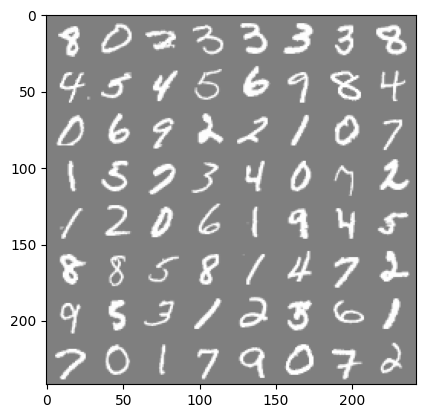

    8     0     2     3     3     3     3     8     4     5     4     5     6     9     8     4     0     6     9     2     2     1     0     7     1     5     7     3     4     0     7     2     1     2     0     6     1     9     4     5     8     8     5     8     1     4     7     2     9     5     3     1     2     3     6     1     7     0     1     7     9     0     7     2


In [12]:
dataiter = iter(trainloader)
images, label = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % label[j].item() for j in range(64)))


In [33]:
test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
test_predictions = []
test_targets = []
test_embeddings = torch.zeros((0, 10), dtype=torch.float32)

for x, y in testloader:
    x, y = x.to(device), y.to(device)
    embeddings, preds = net(x)
    
    test_predictions.extend(preds.detach().cpu().tolist())
    test_targets.extend(y.detach().cpu().tolist())
    test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), dim=0)
    test_imgs = torch.cat((test_imgs, x.detach().cpu()), dim=0)
    
test_imgs = np.array(test_imgs)
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)
test_predictions = np.array(test_predictions)
    

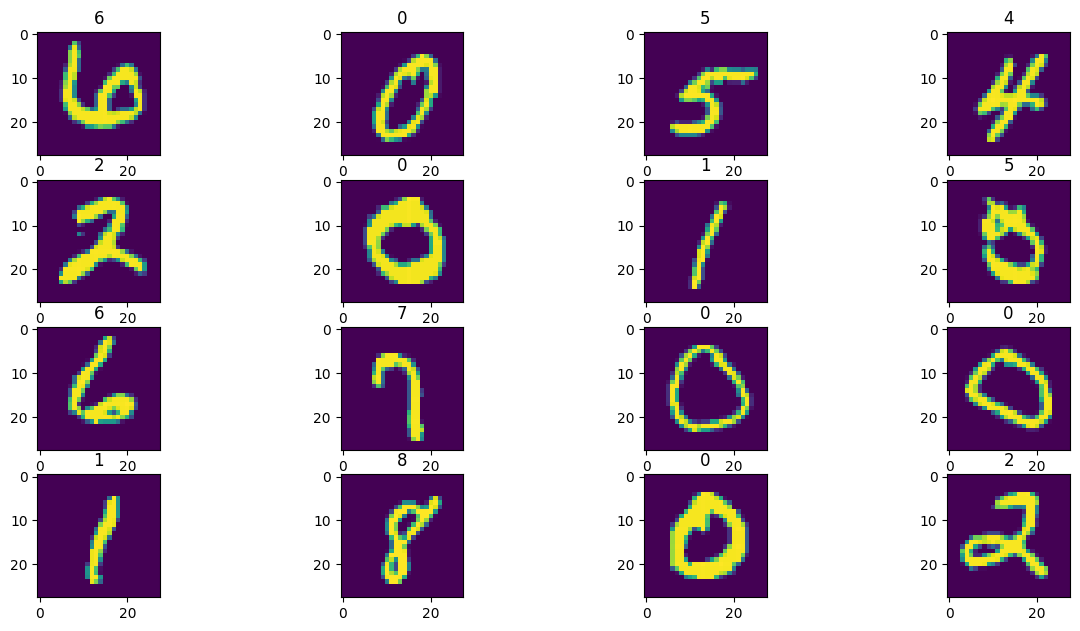

In [34]:
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(8,4,i+1).set_title(y[i].detach().cpu().item())
    plt.imshow(x[i][0].detach().cpu())

In [35]:
from sklearn.manifold import TSNE
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.005s...
[t-SNE] Computed neighbors for 10000 samples in 0.357s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 7.810219
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.423096
[t-SNE] KL divergence after 1000 iterations: 1.402639


/var/folders/s5/bq3q6m7n0015qkgn2sf6gr_w0000gn/T/ipykernel_1514/3813033834.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


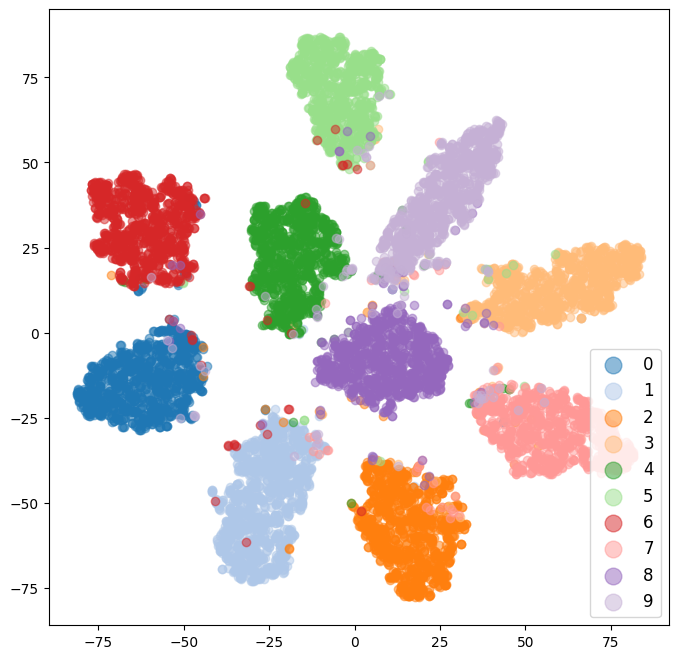

In [39]:
from matplotlib import cm
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

/var/folders/s5/bq3q6m7n0015qkgn2sf6gr_w0000gn/T/ipykernel_1514/2999021269.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


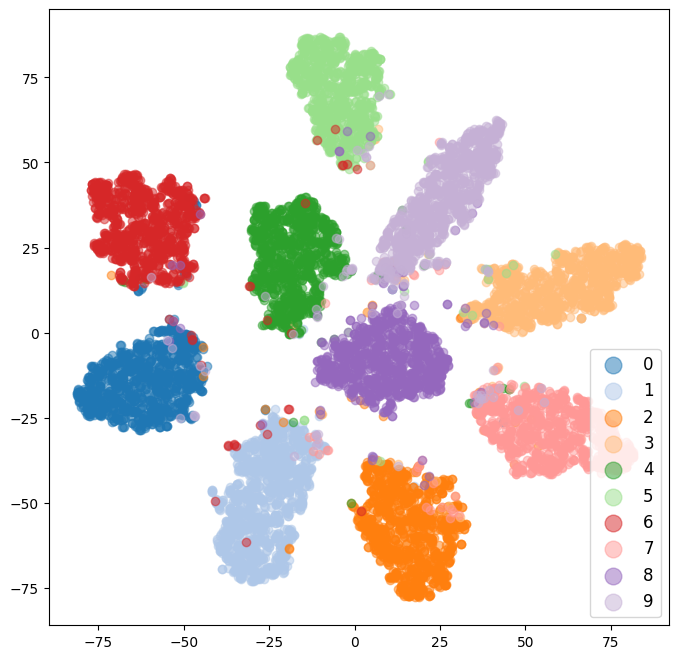

In [40]:
from matplotlib import cm
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = np.where(test_targets == lab)
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [13]:
 # we will save the conv layer weights in this list
model_weights =[]
#we will save the X conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(net.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 2
conv_layers


2
torch.Size([3, 28, 28])
torch.Size([6, 24, 24])
(28, 28)
(24, 24)


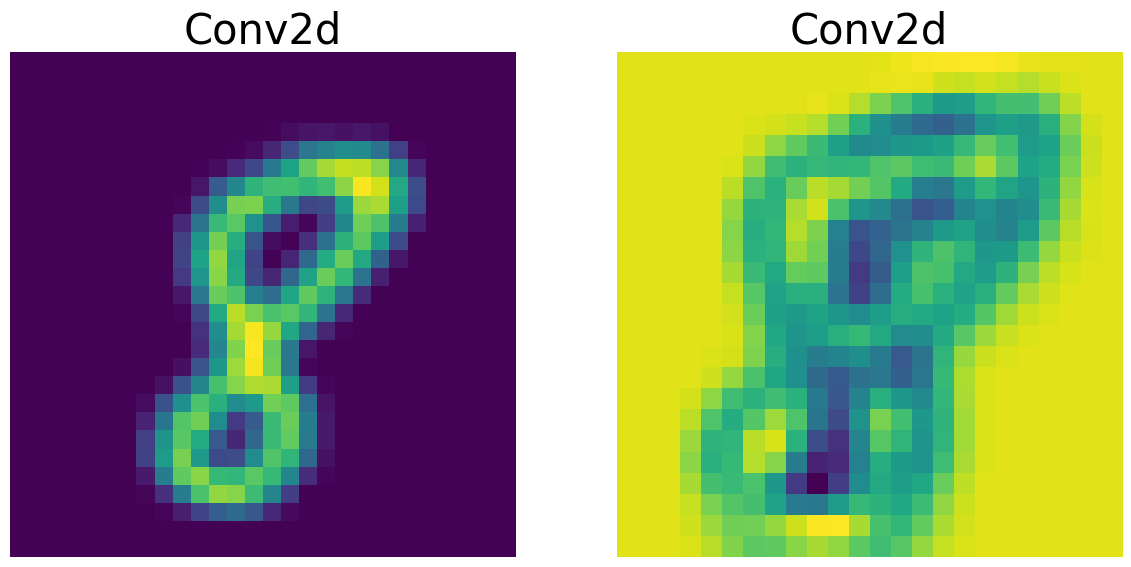

In [102]:
image = images[0]
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)
    
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)
    
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig('feature_maps.jpg', bbox_inches='tight')

In [ ]:
fc2_weights = model_children[-2].weight
